In [1]:
# prompt: unzip original files.zip
# !unzip OriginalFiles.zip > /dev/null


In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [4]:
# Define the base directory where AugmentedAlzheimerDataset is located
base_dir = os.path.join("Original Files", "AugmentedAlzheimerDataset")
# base_dir = os.path.join("data", "OriginalDataset")

# Define paths for each category
mild_demented_path = os.path.join(base_dir, "MildDemented")
moderate_demented_path = os.path.join(base_dir, "ModerateDemented")
non_demented_path = os.path.join(base_dir, "NonDemented")
very_mild_demented_path = os.path.join(base_dir, "VeryMildDemented")

# Create variables with lists of image file paths for each category
mild_demented_images = glob(os.path.join(mild_demented_path, "*"))
moderate_demented_images = glob(os.path.join(moderate_demented_path, "*"))
non_demented_images = glob(os.path.join(non_demented_path, "*"))
very_mild_demented_images = glob(os.path.join(very_mild_demented_path, "*"))

# Optionally, print the number of images found in each folder
print("Mild Demented:", len(mild_demented_images))
print("Moderate Demented:", len(moderate_demented_images))
print("Non Demented:", len(non_demented_images))
print("Very Mild Demented:", len(very_mild_demented_images))

Mild Demented: 8960
Moderate Demented: 6464
Non Demented: 9600
Very Mild Demented: 8960


In [5]:
data = []

data.extend([(img, "MildDemented") for img in mild_demented_images])
data.extend([(img, "ModerateDemented") for img in moderate_demented_images])
data.extend([(img, "NonDemented") for img in non_demented_images])
data.extend([(img, "VeryMildDemented") for img in very_mild_demented_images])

print("Total images:", len(data))

Total images: 33984


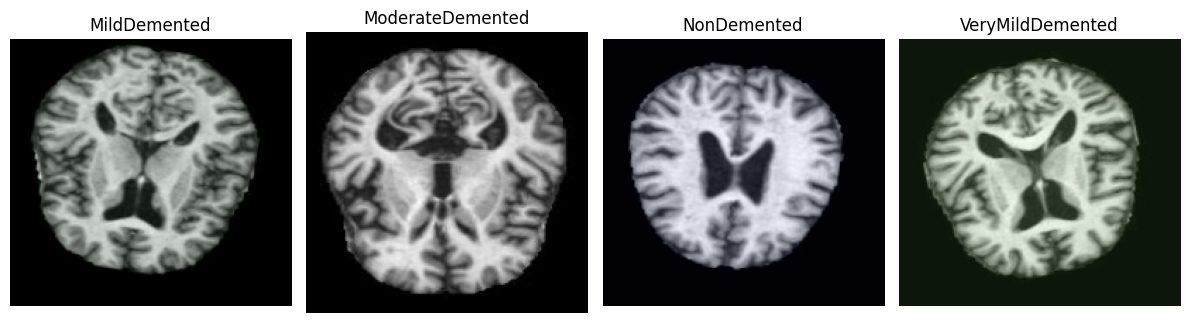

In [6]:
# Define the four categories
categories = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# For each category, select the first image found in data
samples = {cat: next(img for img, label in data if label == cat) for cat in categories}

plt.figure(figsize=(12, 4))
for i, cat in enumerate(categories):
    # Open the image and plot it
    img = Image.open(samples[cat])
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
df = pd.DataFrame(data, columns=['filepaths', 'labels'])

train_images, test_images = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['labels']
)
train_set, val_set = train_test_split(
    train_images, test_size=0.2, random_state=42, stratify=train_images['labels']
)
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(19030, 2)
(10196, 2)
(4758, 2)
(23788, 2)


In [8]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
    target_size=(244,244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
    target_size=(244,244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle= False
)
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
    target_size=(244,244),
    color_mode= 'rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 19030 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.


In [9]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import  EfficientNetB7

img_shape=(244,244,3)
base_model =  EfficientNetB7(
    include_top= False,
    weights= "imagenet",
    input_shape= img_shape,
    pooling= 'max'
)

2025-04-27 12:11:50.409343: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-27 12:11:50.409370: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-04-27 12:11:50.409375: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1745773910.409390 11897867 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745773910.409411 11897867 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
EfficientNetB7_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB7_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB7_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426,011 (245.77 MB)

 Trainable params: 51,795,452 (197.58 MB)

 Non-trainable params: 12,630,559 (48.18 MB)

In [12]:
# # Move the model to the GPU if available
# with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=3,
#         mode='min',
#         restore_best_weights=True,
#         verbose=1
#     )
#     history = EfficientNetB7_model.fit(
#         train,
#         epochs=50,
#         validation_data=val,
#         callbacks=[early_stopping, annealer]
#     )


In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping # Make sure this is imported


physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"MPS device found: {physical_devices[0]}")
    # You could optionally enable memory growth if needed, though often not necessary for MPS
    # tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("MPS device not found. Ensure tensorflow-metal is installed correctly.")
    print("Training will proceed on CPU.")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# The model.fit call remains the same.
# It will automatically leverage the MPS backend if detected and available.
history = EfficientNetB7_model.fit(
    train,
    epochs=5,
    validation_data=val,
    callbacks=[early_stopping, annealer] # Ensure 'annealer' is defined
)

print("Training finished.")


MPS device found: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 565s 950ms/step - accuracy: 0.3924 - loss: 2.2203 - val_accuracy: 0.6530 - val_loss: 0.8727 - learning_rate: 0.0010
Epoch 2/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 549s 923ms/step - accuracy: 0.5611 - loss: 1.6966 - val_accuracy: 0.7512 - val_loss: 0.7008 - learning_rate: 9.5000e-04
Epoch 3/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 553s 929ms/step - accuracy: 0.6599 - loss: 1.1009 - val_accuracy: 0.8153 - val_loss: 0.4627 - learning_rate: 9.0250e-04
Epoch 4/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 555s 932ms/step - accuracy: 0.7527 - loss: 0.6878 - val_accuracy: 0.8550 - val_loss: 0.3737 - learning_rate: 8.5737e-04
Epoch 5/5
595/595 ━━━━━━━━━━━━━━━━━━━━ 550s 924ms/step - accuracy: 0.8202 - loss: 0.4815 - val_accuracy: 0.8918 - val_loss: 0.2978 - learning_rate: 8.1451e-04
Restoring model weights from the end of the best epoch: 5.
Training finished.


In [15]:
model_save_path = 'efficientnetb7_trained_model.keras'

print(f"\nSaving trained model to {model_save_path}...")
try:
    # Use the .keras format for saving (recommended)
    EfficientNetB7_model.save(model_save_path)
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")


Saving trained model to efficientnetb7_trained_model.keras...
Model saved successfully.


In [16]:
train_loss, train_accuracy =  EfficientNetB7_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB7_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB7_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

595/595 ━━━━━━━━━━━━━━━━━━━━ 273s 458ms/step - accuracy: 0.9238 - loss: 0.1960

Train loss: 0.20
Train Accuracy: 92.42 %
149/149 ━━━━━━━━━━━━━━━━━━━━ 69s 461ms/step - accuracy: 0.8978 - loss: 0.2838

validation loss: 0.30
Validation Accuracy: 89.18 %
319/319 ━━━━━━━━━━━━━━━━━━━━ 149s 468ms/step - accuracy: 0.8928 - loss: 0.2980

test loss: 0.30
test Accuracy: 89.04 %


In [17]:
result = EfficientNetB7_model.evaluate(test, verbose=1)
print(result)

319/319 ━━━━━━━━━━━━━━━━━━━━ 147s 460ms/step - accuracy: 0.8928 - loss: 0.2980
[0.3048268258571625, 0.8904472589492798]


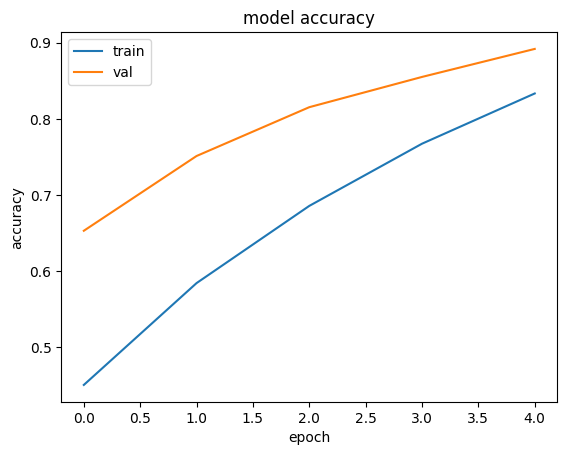

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

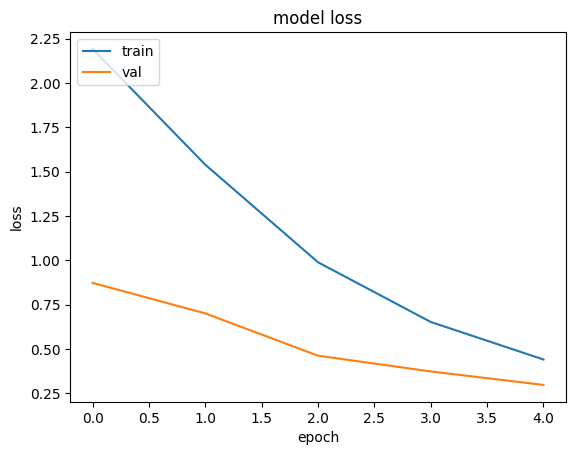

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB7_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

319/319 ━━━━━━━━━━━━━━━━━━━━ 163s 490ms/step
                  precision    recall  f1-score   support

    MildDemented       0.91      0.93      0.92      2688
ModerateDemented       0.97      1.00      0.99      1940
     NonDemented       0.89      0.80      0.84      2880
VeryMildDemented       0.82      0.87      0.84      2688

        accuracy                           0.89     10196
       macro avg       0.90      0.90      0.90     10196
    weighted avg       0.89      0.89      0.89     10196

Accuracy of the Model: 89.0%
